In [103]:
import torch
import torch.nn as nn
import torch.nn.functional as F

import numpy as np
import matplotlib.pyplot as plt

In [104]:
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
print(device)

cuda


In [ ]:

c=1.0 # velocidad de la onda
l=1.0 # amplitud de la onda
n=2   # modo normal

lr = 1e-3
layers = 5
neuronas = 128
epocs = 100_000 # la mejora parece estar en la cantidad de epocs y no en el grosor ni profundidad de la red

In [106]:
# Modelo ecuacion de onda u(x,t)

class FunAct(nn.Module):
    def forward(self,x):
        return torch.tanh(x)


class MLP(nn.Module):
    def __init__(self, in_dim=2, out_dim=1, width=neuronas, depth=layers):
        super().__init__()
        capas = [nn.Linear(in_dim, width), FunAct()]
        for _ in range(depth - 1):
            capas += [nn.Linear(width, width), FunAct()]
        capas +=[nn.Linear(width, out_dim)]
        self.net=nn.Sequential(*capas)    

    def forward(self, x,t):
        XT = torch.cat([x, t], dim=1)
        return self.net(XT)
        

In [107]:
u = MLP().to(device)

In [108]:
def D(y, x):
    return torch.autograd.grad(y,x, torch.ones_like(y), retain_graph = True, create_graph= True)[0]
def psi(u,x,t):
    
    u_x = D(u,x)
    u_xx = D(u_x,x)

    u_t = D(u,t)
    u_tt = D(u_t,t)

    return u_tt - c*c*u_xx

def u_forward(t):
    return u(t)

In [109]:
### muestreo

N_poblado   = 5000
N_condicion = 200


In [110]:
optimizador = torch.optim.Adam(u.parameters(), lr)

In [111]:
loss_valores = []

for step in range(epocs):

    optimizador.zero_grad()


    t_poblado   = torch.rand((N_poblado, 1), device=device, requires_grad=True)
    x_poblado   = torch.rand((N_poblado, 1), device=device, requires_grad=True)

    t_condicion = torch.rand((N_condicion,1), device=device, requires_grad=True)
    x_condicion = torch.rand((N_condicion,1), device=device, requires_grad=True)

    ### condiciones de borde
    x0 = torch.zeros_like(x_condicion, device=device, requires_grad=True)
    xl = torch.ones_like(x_condicion,  device=device, requires_grad=True)*l

    ### condiciones iniciales
    t0 = torch.zeros_like(t_condicion, device=device, requires_grad=True)

    residuo = psi(u(x_poblado,t_poblado),x_poblado,t_poblado)
    loss_residuo = (residuo**2).mean()

    u0t = u(x0,t_condicion) 
    ult = u(xl,t_condicion) 

    loss_cb = (u0t**2).mean() + (ult**2).mean()

    ux0 = u(x_condicion,t0)
    ux0_t = D(ux0,t0)
    fx = torch.sin(n*torch.pi*x_condicion/l)
    gx = torch.zeros_like(ux0_t)

    loss_ci = ((ux0-fx)**2).mean() + ((ux0_t-gx)**2).mean()

    loss = loss_residuo + loss_cb + loss_ci

    loss_valores.append(loss.item())

    loss.backward()

    optimizador.step()

    if step % 200 == 0:
        print(f"step {step:4d} | loss {loss.item():.3e}")


step    0 | loss 5.415e-01
step  200 | loss 3.187e-01
step  400 | loss 1.705e-01
step  600 | loss 1.130e-01
step  800 | loss 1.049e-01
step 1000 | loss 9.829e-02
step 1200 | loss 9.938e-02
step 1400 | loss 8.831e-02
step 1600 | loss 7.194e-02
step 1800 | loss 7.568e-02
step 2000 | loss 5.625e-02
step 2200 | loss 4.463e-02
step 2400 | loss 3.491e-02
step 2600 | loss 2.596e-02
step 2800 | loss 1.759e-02
step 3000 | loss 1.287e-02
step 3200 | loss 1.190e-02
step 3400 | loss 1.671e-02
step 3600 | loss 1.123e-02
step 3800 | loss 7.658e-03
step 4000 | loss 5.387e-03
step 4200 | loss 1.086e-02
step 4400 | loss 5.258e-03
step 4600 | loss 1.185e-02
step 4800 | loss 6.745e-03
step 5000 | loss 9.458e-03
step 5200 | loss 7.021e-03
step 5400 | loss 3.845e-03
step 5600 | loss 3.887e-03
step 5800 | loss 4.101e-03
step 6000 | loss 4.555e-03
step 6200 | loss 3.040e-03
step 6400 | loss 3.000e-03
step 6600 | loss 3.382e-03
step 6800 | loss 2.428e-03
step 7000 | loss 2.442e-03
step 7200 | loss 2.239e-03
s

Text(0, 0.5, 'Log Loss')

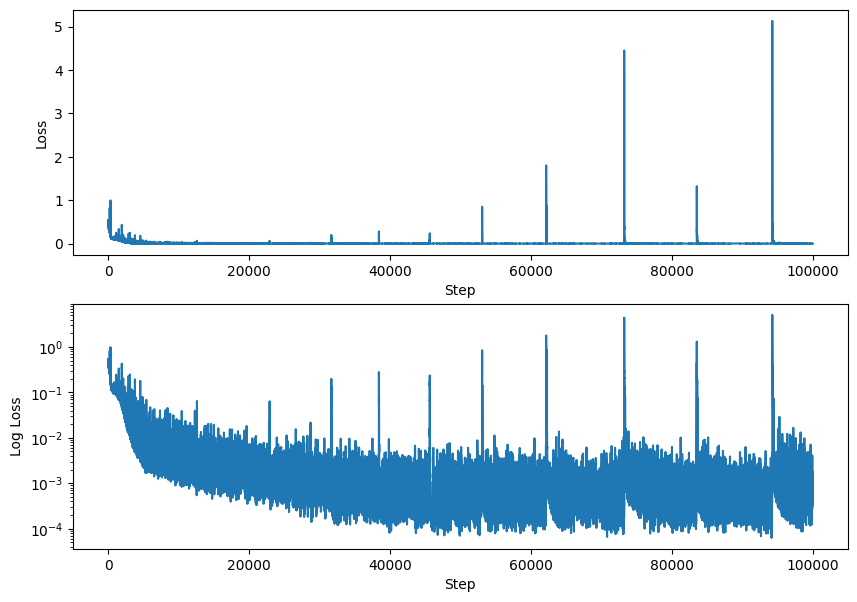

In [112]:
plt.figure(figsize=(10,7))

plt.subplot(2,1,1)
plt.plot(loss_valores)
plt.xlabel("Step"); plt.ylabel('Loss')
plt.subplot(2,1,2)
plt.plot(loss_valores)
plt.yscale('log')  # si baja exponencialmente
plt.xlabel("Step"); plt.ylabel("Log Loss")

In [113]:
def u_exacta(x,t):
    A=1
    l=1
    return A*np.cos(n*np.pi*c*t/l)*np.sin(n*np.pi*x/l)

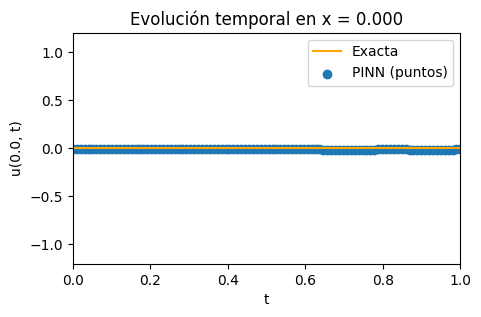

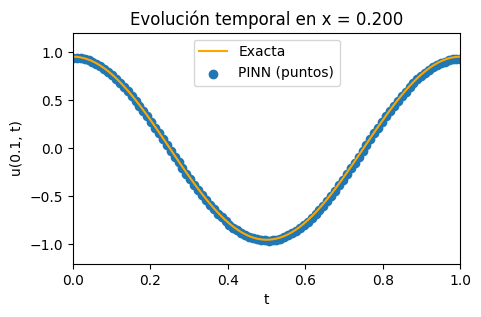

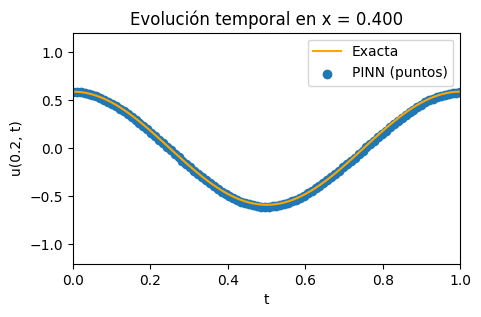

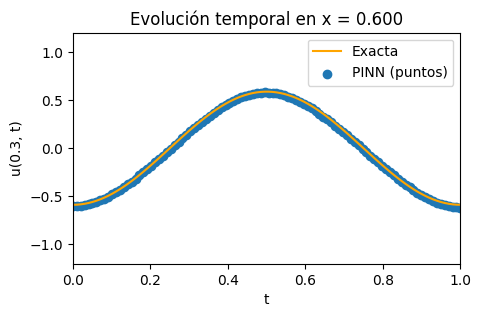

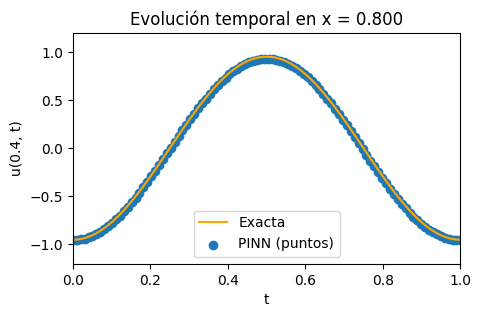

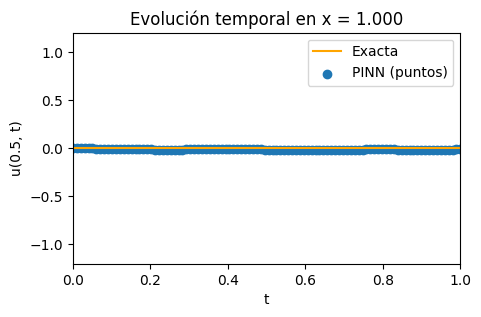

In [127]:
# dn cantidad de secciones en la que se divide l
dn = 5
for i in range(dn+1):
    dx = l*i/dn
    x0 = torch.tensor(dx, device=device)  

    with torch.no_grad():
        # malla suave en t para la curva
        tmin, tmax = 0.0, 1.0   
        tg = torch.linspace(tmin, tmax, 100, device=device).view(-1, 1)
        xg = torch.full_like(tg, x0)

        u_ex = u_exacta(xg.cpu().numpy().ravel(), tg.cpu().numpy().ravel())
        u_num = u(xg, tg).detach().cpu().numpy().ravel()

        t_pts = t_poblado.detach().cpu().numpy().ravel()
        u_pts = u(torch.full_like(t_poblado, x0), t_poblado).detach().cpu().numpy().ravel()

    plt.figure(figsize=(5,3))
    plt.plot(tg.detach().cpu().numpy().ravel(), u_ex,color='orange', label='Exacta')
    plt.scatter(tg.detach().cpu().numpy().ravel(), u_num, label='PINN (puntos)')
    plt.xlabel('t')
    plt.ylabel('u('+str(i/10)+', t)')
    plt.title(f'Evolución temporal en x = {float(x0):.3f}')
    plt.xlim(tmin,tmax); plt.ylim(-l-l/5,l+l/5) # sin fijar estos limites se evidencia que el mayor error es en los bordes x=0 y x=l
    plt.legend()
plt.show()


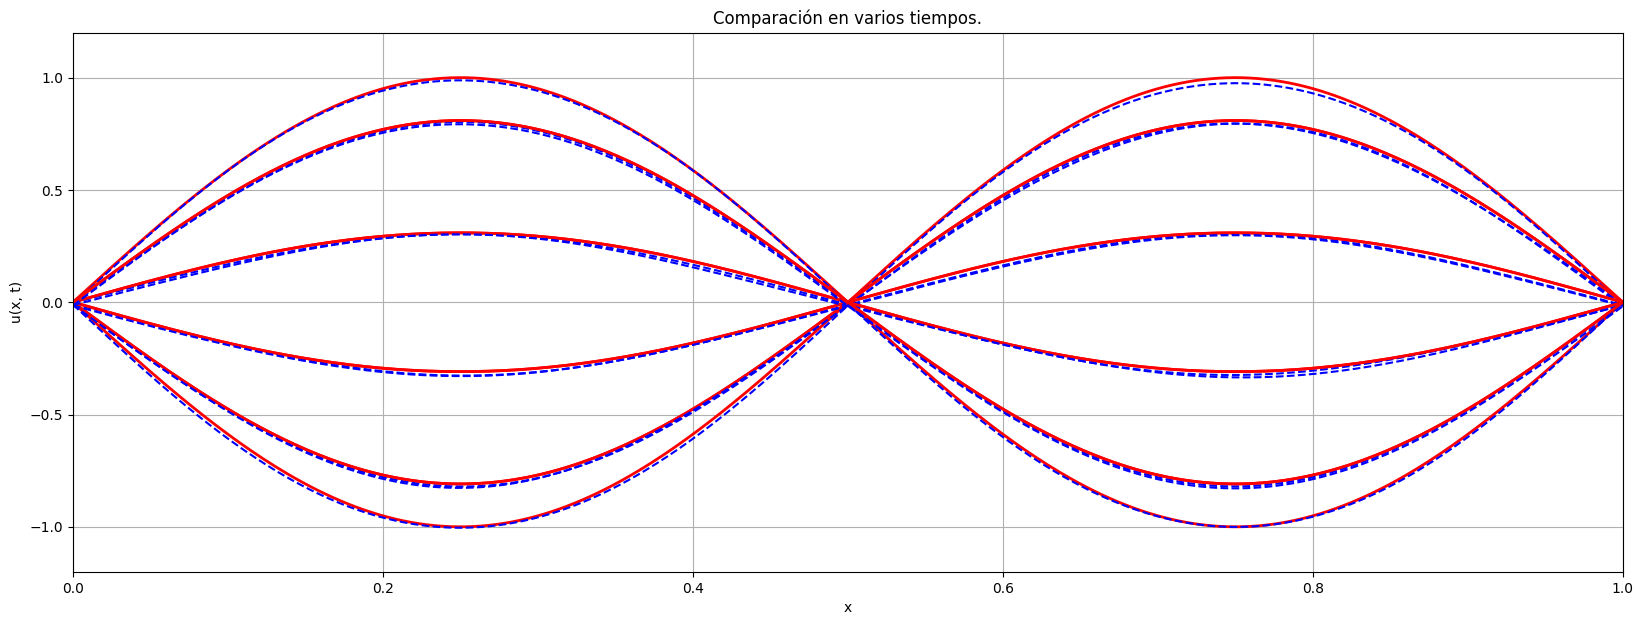

MSE @ t=0.900: 2.722e-04 | Error relativo L2: 2.887e-02


In [126]:
tmax = 10

plt.figure(figsize=(20,7))

for i in range(tmax):
    t_i = float(i/10)  

    with torch.no_grad():
        xg = torch.linspace(0.0, float(l), 400, device=device).view(-1, 1)
        tg = torch.full_like(xg, t_i)

        # PINN en t = t_i
        u_num = u(xg, tg).squeeze().detach().cpu().numpy()

        # Exacta en t = t_i 
        x_np = xg.detach().cpu().numpy().ravel()
        t_np = np.full_like(x_np, t_i, dtype=float)
        u_ex  = u_exacta(x_np, t_np)
        u_ex  = np.ravel(u_ex)  # por si u_exacta devuelve 2D

    # metricas de error en el corte temporal
    mse = np.mean((u_num - u_ex)**2)
    rel_L2 = np.linalg.norm(u_num - u_ex) / max(1e-12, np.linalg.norm(u_ex))

    plt.plot(x_np, u_ex,  label='Solución exacta', linewidth=2, color='red')
    plt.plot(x_np, u_num, label='PINN', linestyle='--',color='blue')
    plt.xlabel('x')
    plt.ylabel(f'u(x, t)')
    plt.title('Comparación en varios tiempos.')
    plt.xlim(0,l); plt.ylim(-l-l/5,l+l/5)
    plt.grid(True)

plt.show()

print(f"MSE @ t={t_i:.3f}: {mse:.3e} | Error relativo L2: {rel_L2:.3e}")
